In [ ]:
# HIT: Restart session
!pip install numpy==1.26.4
!pip install -U gensim
!pip install utils

In [ ]:
from rich import print as rprint
import requests
import gensim.downloader as gensim_api
from gensim.models.keyedvectors import KeyedVectors
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def plot_history(history: dict) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(history["accuracy"], label="Accuracy")
    axes[0].plot(history["val_accuracy"], label="Validation accuracy")
    axes[0].set_title("Accuracy")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    axes[1].plot(history["loss"], label="Loss")
    axes[1].plot(history["val_loss"], label="Validation loss")
    axes[1].set_title("Loss")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.show()

In [ ]:
def get_raw_corpus(lang: str) -> str:
    """Obtiene el corpus crudo de Universal Dependencies

    Parameters
    ----------
    lang: str
        Idioma del corpus. Puede ser "es" o "en"

    Return
    ------
    str
        Corpus crudo en formato CoNLL
    """
    file_variants = ["train", "test", "dev"]
    result = dict.fromkeys(file_variants)
    DATASETS = {"es": ["UD_Spanish-AnCora", "es_ancora-ud"], "en": ["UD_English-GUM", "en_gum-ud"]}
    repo, file_name = DATASETS[lang]
    for variant in file_variants:
        url = f"https://raw.githubusercontent.com/UniversalDependencies/{repo}/refs/heads/master/{file_name}-{variant}.conllu"
        r = requests.get(url)
        result[variant] = r.text
    return result

In [ ]:
raw_corpus = get_raw_corpus("en")
raw_spanish_corpus = get_raw_corpus("es")

In [ ]:
class Token(dict):
    """Modela cada renglon de un corpus en formato CoNLL
    """
    pass

In [ ]:
t = Token(
    {
        "ID": "1",
        "FORM": "Las",
        "LEMMA": "el",
        "UPOS": "DET",
        "FEATS": "Definite=Def|Gender=Fem|Number=Plur|PronType=Art",
    }
)
rprint(t)

{
    'ID': '1',
    'FORM': 'Las',
    'LEMMA': 'el',
    'UPOS': 'DET',
    'FEATS': 'Definite=Def|Gender=Fem|Number=Plur|PronType=Art'
}

In [ ]:
import re

class CoNLLDictorizer:
    """Convierte un corpus en formato CoNLL a una lista de diccionarios

    Define los métodos fit, transform y fit_transform para que
    sea compatible con la api de scikit-learn.

    Parameters
    ----------
    column_names: list
        Nombre de las columnas del corpus.
        Default: ["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]
    sent_sep: str
        Separador de oraciones. Default: "\n\n"
    col_sep: str
        Separador de columnas. Default: "\t+"
    """
    DEFAULT_COLS = [
        "ID",
        "FORM",
        "LEMMA",
        "UPOS",
        "XPOS",
        "FEATS",
        "HEAD",
        "DEPREL",
        "HEAD",
        "DEPS",
        "MISC",
    ]

    def __init__(self, column_names: list=DEFAULT_COLS, sent_sep="\n\n", col_sep="\t+"):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus: str) -> list[Token]:
        """Convierte un corpus en formato CoNLL a una lista de diccionarios.

        Parameters
        ----------
        corpus: str
            Corpus en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens del corpus
        """
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence: list[str]) -> list[Token]:
        """Preprocesa una oración en formato CoNLL

        Ignora las lineas que comienzan con "#" y separa
        cada línea en un diccionario.

        Parameters
        ----------
        sentence: str
            Oracion en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens de la oración
        """
        rows = re.split("\n", sentence)
        rows = [row for row in rows if row[0] != "#"]
        return [
            Token(dict(zip(self.column_names, re.split(self.col_sep, row))))
            for row in rows
        ]

In [ ]:
conll_dict = CoNLLDictorizer()

In [ ]:
corpora = {}
for variant in ["train", "test", "dev"]:
    corpora[variant] = conll_dict.transform(raw_corpus[variant])

In [ ]:
spanish_corpora = {}
for variant in ["train", "test", "dev"]:
    spanish_corpora[variant] = conll_dict.transform(raw_spanish_corpus[variant])

In [ ]:
def extract_pairs(sentence: list[Token], word_key="FORM", pos_key="UPOS"):
    """ Extrae las palabras y sus etiquetas POS

    Parameters
    ----------
    sentence: list[Token]
        Oracion en formato CoNLL
    word_key: str
        Nombre de la columna que contiene la palabra. Default: "FORM"
    pos_key: str
        Nombre de la columna que contiene la etiqueta POS. Default: "UPOS"

    Return
    ------
    tuple
        Tupla con las palabras y sus etiquetas POS
    """
    _input, target = [], []
    for token in sentence:
        _input += [token[word_key]]
        target += [token.get(pos_key, None)]
    return _input, target

In [ ]:
train_pairs = [extract_pairs(sentence) for sentence in corpora["train"]]
val_pairs = [extract_pairs(sentence) for sentence in corpora["dev"]]
test_pairs = [extract_pairs(sentence) for sentence in corpora["test"]]

In [ ]:
train_sent_words, train_sent_pos = zip(*train_pairs)
val_sent_words, val_sent_pos = zip(*val_pairs)
test_sent_words, test_sent_pos = zip(*test_pairs)

In [ ]:
vectors = gensim_api.load("glove-wiki-gigaword-100")

In [ ]:
def get_embeddings(model: KeyedVectors) -> dict[str, torch.FloatTensor]:
    """Obtiene los embeddings de las palabras del modelo

    Parameters
    ----------
    model: KeyedVectors
        Modelo de embeddings

    Return
    ------
    dict[str, torh.FloatTensor]
        Diccionario con las palabras como keys y los embeddings como values
    """
    embeddings = {}
    for word, idx in model.key_to_index.items():
        embeddings[word] = torch.FloatTensor(vectors[idx].copy())
    return embeddings

In [ ]:
embeddings = get_embeddings(vectors)

In [ ]:
# Extracting the training set
rprint(train_sent_words[0])
rprint(train_sent_pos[0])

['Aesthetic', 'Appreciation', 'and', 'Spanish', 'Art', ':']

['ADJ', 'NOUN', 'CCONJ', 'ADJ', 'NOUN', 'PUNCT']

In [ ]:
# Todas las palabras a minusculas para que sea compatible con GLoVe
train_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in train_sent_words]
val_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in val_sent_words]
test_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in test_sent_words]

#### Indices

In [ ]:
corpus_words_rnn = sorted(set([word for sentence in train_sent_words_rnn for word in sentence]))
pos_list_rnn = sorted(set([pos for sentence in train_sent_pos for pos in sentence]))

In [ ]:
embeddings_words_rnn = embeddings.keys()
vocabulary = set(corpus_words_rnn + list(embeddings_words_rnn))

In [ ]:
# Start on 2 because id 0 will be pad simbol and 1 will be UNK
idx2word = dict(enumerate(vocabulary), start=2)
idx2pos = dict(enumerate(pos_list_rnn), start=1)

word2idx = {v: k for k, v in idx2word.items()}
pos2idx = {v: k for k, v in idx2pos.items()}

In [ ]:
def to_index(corpus: list[list[str]], word2idx: dict[str, int], unk_id: int = 1) -> torch.LongTensor:
    indexes = []
    for sent in corpus:
        sent_indexes = torch.LongTensor(
            list(map(lambda word: word2idx.get(word, unk_id), sent))
        )
        indexes += [sent_indexes]
    return indexes


In [ ]:
t = to_index(train_sent_words_rnn[:2], word2idx)

In [ ]:
for sent in t:
    for word in sent:
        print(idx2word[int(word)])

aesthetic
appreciation
and
spanish
art
:
insights
from
eye
-
tracking


In [ ]:
X_train_idx_rnn = to_index(train_sent_words_rnn, word2idx)
Y_train_idx_rnn = to_index(train_sent_pos, pos2idx)

In [ ]:
X_val_idx_rnn = to_index(val_sent_words_rnn, word2idx)
Y_val_idx_rnn = to_index(val_sent_pos, pos2idx)

In [ ]:
X_test_idx_rnn = to_index(test_sent_words_rnn, word2idx)
Y_test_idx_rnn = to_index(test_sent_pos, pos2idx)

#### Padding

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
pad_sequence(X_train_idx_rnn[41:43], batch_first=True, padding_value=0)

tensor([[336200, 400758, 321782, 160421, 281310, 242400, 218827, 120054, 309923,
          78699, 287778,  54047,  13845, 160186,  55409, 234316, 213294,  99536,
         139057, 215739, 155797,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [ 99137, 309923,  78699,  91653, 238561, 372925, 147611, 277948, 198676,
         321782, 348706, 156122, 321782, 160186, 287358, 392177, 397002, 309923,
         127259, 238751, 155035, 273830, 369644,  77698, 321782,  22261, 321782,
         234316, 122005,    750,  52967, 142536, 155797]])

In [ ]:
X_train_rnn = pad_sequence(X_train_idx_rnn, batch_first=True, padding_value=0)
Y_train_rnn = pad_sequence(Y_train_idx_rnn, batch_first=True, padding_value=0)

In [ ]:
X_val_rnn = pad_sequence(X_val_idx_rnn, batch_first=True, padding_value=0)
Y_val_rnn = pad_sequence(Y_val_idx_rnn, batch_first=True, padding_value=0)

In [ ]:
X_test_rnn = pad_sequence(X_test_idx_rnn, batch_first=True, padding_value=0)
Y_test_rnn = pad_sequence(Y_test_idx_rnn, batch_first=True, padding_value=0)

#### Embeddings para RNN

In [ ]:
EMBEDDING_DIM = 100

In [ ]:
embedding_table = torch.randn((len(vocabulary) + 2, EMBEDDING_DIM)) / 10

In [ ]:
for word in vocabulary:
    if word in embeddings:
        embedding_table[word2idx[word]] = embeddings[word]

### La Recurrent Neural Net con pytorch

In [ ]:
class RnnModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
            )
        self.recurrent = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        if bidirectional:
            # Dos veces las unidades si es bidireccional
            self.linear = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rec_out, _ = self.recurrent(embeds)
        logist = self.linear(rec_out)
        return logist

In [ ]:
rnn_model = RnnModel(
    embedding_table,
    hidden_size=128,
    num_classes=len(pos2idx) + 1,
    freeze_embeddings=False,
    num_layers=2,
    bidirectional=True
).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.NAdam(rnn_model.parameters(), lr=0.005)

#### Training loop

In [ ]:
EPOCHS = 10

In [ ]:
train_dataset_rnn = TensorDataset(X_train_rnn, Y_train_rnn)
train_dataloader_rnn = DataLoader(train_dataset_rnn, batch_size=512, shuffle=True)

In [ ]:
val_dataset_rnn = TensorDataset(X_val_rnn, Y_val_rnn)
val_dataloader_rnn = DataLoader(val_dataset_rnn, batch_size=2048, shuffle=False)

In [ ]:
test_dataset_rnn = TensorDataset(X_test_rnn, Y_test_rnn)
test_dataloader_rnn = DataLoader(test_dataset_rnn, batch_size=2048, shuffle=False)

In [ ]:
def evaluate_rnn(model: nn.Module, loss_fn: nn.Module, dataloader: DataLoader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        accuracy = 0
        t_words = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch_pred = model(X_batch)
            current_loss = loss_fn(
                y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
                y_batch.reshape(-1)
            )
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            total_loss += n_words + current_loss.item()
            accuracy += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()
        return total_loss / t_words, accuracy / t_words

In [ ]:
MODELS_PATH = "./models"

In [ ]:
rnn_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}
for epoch in trange(EPOCHS):
    train_loss, train_acc, t_words = 0, 0, 0
    rnn_model.train()
    for X_batch, y_batch in tqdm(train_dataloader_rnn):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = rnn_model(X_batch)
        loss = loss_fn(
            y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
            y_batch.reshape(-1)
            )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            train_loss += n_words * loss.item()
            train_acc += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()

    rnn_model.eval()
    with torch.no_grad():
        rnn_history["accuracy"].append(train_acc / t_words)
        rnn_history["loss"].append(train_loss / t_words)
        val_loss, val_acc = evaluate_rnn(rnn_model, loss_fn, val_dataloader_rnn)
        rnn_history["val_loss"].append(val_loss)
        rnn_history["val_accuracy"].append(val_acc)
    torch.save(rnn_model.state_dict(), f"{MODELS_PATH}/pos_tagger_rnn_{device}_{epoch}.pth")
torch.save(rnn_history, f"{MODELS_PATH}/pos_tagger_rnn.history")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

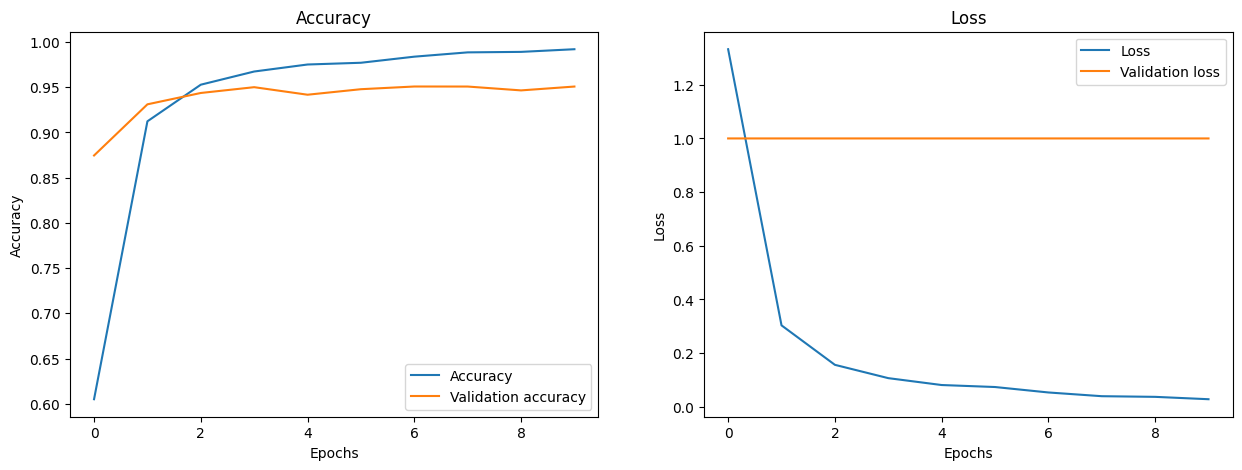

In [ ]:
plot_history(rnn_history)

In [ ]:
_, accuracy_rnn = evaluate_rnn(rnn_model, loss_fn, test_dataloader_rnn)
rprint(f"Accuracy (RNN): {accuracy_rnn * 100:.2f}%")

Accuracy (RNN): 93.70%

#Práctica

In [ ]:
# Seleccionar 100 palabras aleatorias del modelo GloVe (estáticos)
random_words_static = random.sample(list(embeddings.keys()), 100)
static_embeddings = {word: embeddings[word] for word in random_words_static}

print("Embeddings estáticos (GloVe):")
for word, vector in static_embeddings.items():
    print(f"{word}: {vector.shape}")

# Seleccionar 100 palabras del vocabulario del RNN (dinámicos)
random_words_dynamic = random.sample(list(word2idx.keys()), 100)

# Convertir palabras a índices y obtener embeddings del modelo
indices = torch.tensor(
    [word2idx[word] for word in random_words_dynamic],
    dtype=torch.long,
    device=device
)
dynamic_embeddings = rnn_model.embedding(indices).detach().cpu()

# Crear diccionario con la muestra de palabras y sus embeddings dinámicos
dynamic_embeddings_dict = {
    word: embedding.numpy()
    for word, embedding in zip(random_words_dynamic, dynamic_embeddings)
}

print("\nEmbeddings dinámicos (RNN):")
for word, vector in dynamic_embeddings_dict.items():
    print(f"{word}: {vector.shape}")

Embeddings estáticos (GloVe):
seventeenth-century: torch.Size([100])
nige: torch.Size([100])
cimbalom: torch.Size([100])
enceinte: torch.Size([100])
vengeful: torch.Size([100])
gotter: torch.Size([100])
mid-fifties: torch.Size([100])
lancair: torch.Size([100])
houghton: torch.Size([100])
gusinje: torch.Size([100])
300-dollar: torch.Size([100])
sacirbey: torch.Size([100])
kwtv: torch.Size([100])
minoris: torch.Size([100])
always-on: torch.Size([100])
carrickshock: torch.Size([100])
sauk: torch.Size([100])
agreed-upon: torch.Size([100])
trl: torch.Size([100])
lewisham: torch.Size([100])
ajok: torch.Size([100])
giannakis: torch.Size([100])
megazone: torch.Size([100])
gfkpoll.com: torch.Size([100])
misallocation: torch.Size([100])
weadick: torch.Size([100])
nwa: torch.Size([100])
brownies: torch.Size([100])
montclair: torch.Size([100])
39.2: torch.Size([100])
62,000: torch.Size([100])
ellinwood: torch.Size([100])
poltergeist: torch.Size([100])
ba937: torch.Size([100])
onnes: torch.Size([10

In [ ]:
#Para facilitar el procedimiento y no realizar lo mismo dos veces, definimos una función para graficar los embeddings y el clustering
def plot_clusters(embeddings_dict, n_clusters=5, pos_embeddings=None):
    # Convertir a arrays
    words = list(embeddings_dict.keys())
    vectors = np.array([v.numpy() if isinstance(v, torch.Tensor) else v for v in embeddings_dict.values()])

    # Reducción de dimensionalidad con PCA
    reducer = PCA(n_components=2)
    reduced_vectors = reducer.fit_transform(vectors)


    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(vectors)


    # Plot
    plt.figure(figsize=(12, 8))
    colors = ['#FFD700', '#4B0082', '#00FF00', '#FF0000', '#00BFFF']  # 5 colores distintos

    for cluster_id in range(n_clusters):
        cluster_points = reduced_vectors[clusters == cluster_id]
        plt.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            color=colors[cluster_id % len(colors)],
            label=f'Cluster {cluster_id}',
            alpha=0.5
        )

        # Anotar algunas palabras
        for i, (x, y) in enumerate(cluster_points):
            if i % 3 == 0:  # Anotar 1 de cada 3 para no saturar
                plt.annotate(
                    words[np.where(clusters == cluster_id)[0][i]],
                    (x, y),
                    fontsize=8,
                    alpha=0.7
                )

    plt.title("Embeddings en 2D con Clustering")
    #Habilitamos la opción de agregar las etiquetas POS al gráfico
    if pos_embeddings is not None:
        symbols=['.', ',', 'o', 'v' ,'^', '1', '2', '3', '4', '8', 's', 'p', '*', '+', 'x', 'D', '|', '_']
        print(len(symbols))
        pos_embeddings_reduced = reducer.fit_transform(list(pos_embeddings.values()))
        for i,pos in enumerate(pos_embeddings.items()):
            plt.scatter(pos_embeddings_reduced[i][0], pos_embeddings_reduced[i][1], color='black', marker=symbols[i%len(symbols)],alpha=0.8)
            plt.annotate(pos[0], (pos_embeddings_reduced[i][0], pos_embeddings_reduced[i][1]), fontsize=8, alpha=0.7)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


Clustering para embeddings estáticos (GloVe)


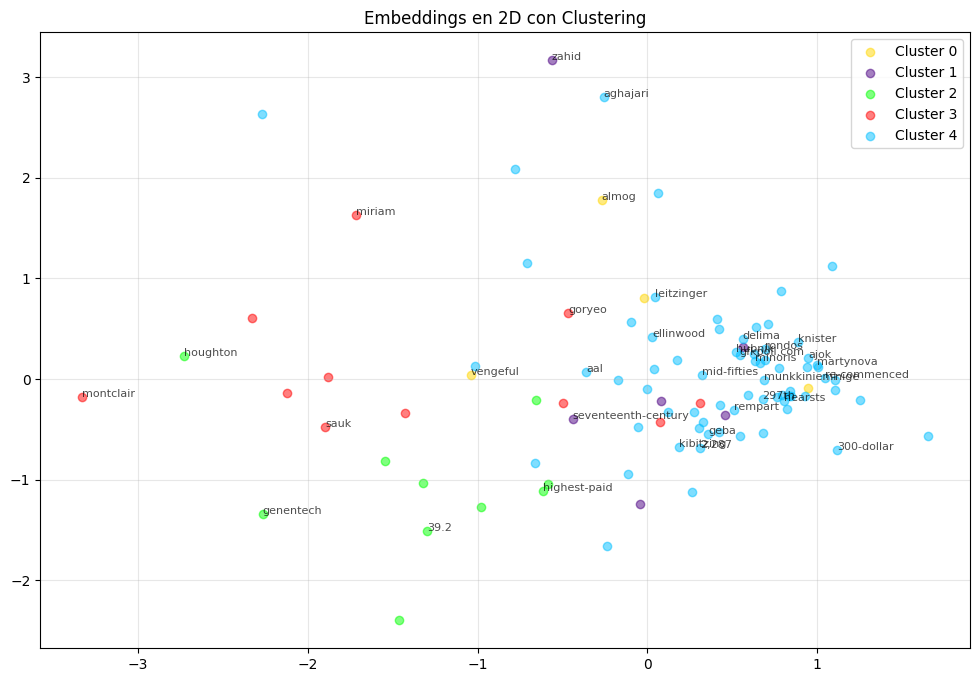

In [ ]:
# -----------------------------------------------------------
# Para embeddings estáticos
# -----------------------------------------------------------
print("Clustering para embeddings estáticos (GloVe)")
plot_clusters(static_embeddings, n_clusters=5)



Clustering para embeddings dinámicos (RNN)


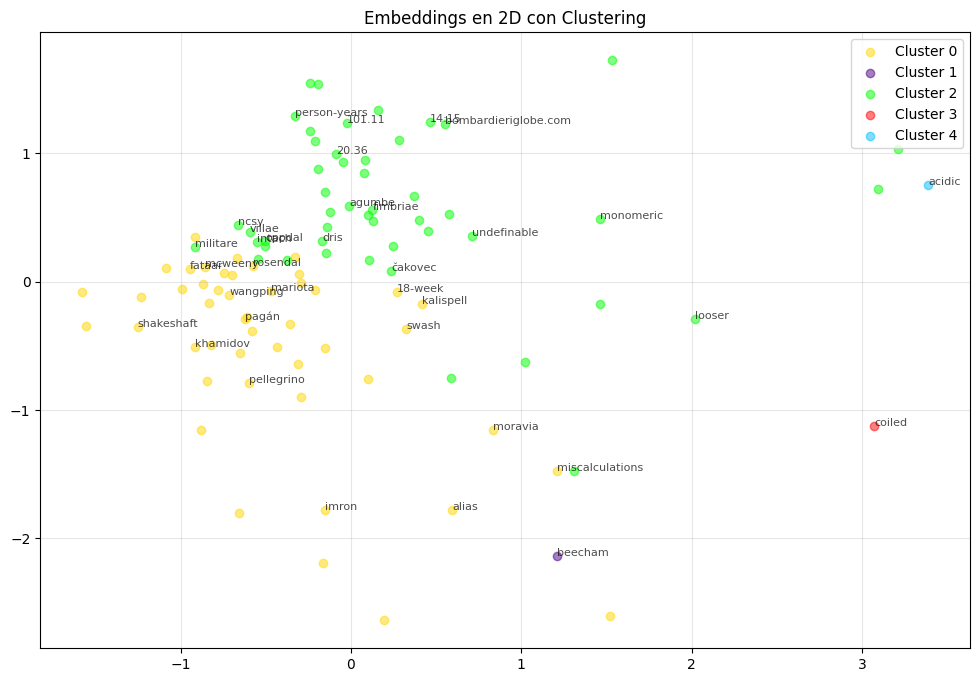

In [ ]:

# -----------------------------------------------------------
# Para embeddings dinámicos (RNN)
# -----------------------------------------------------------
print("\nClustering para embeddings dinámicos (RNN)")
plot_clusters(dynamic_embeddings_dict, n_clusters=5)

In [ ]:
# Obtener embeddings POS desde la capa lineal del modelo
pos_embeddings_dynamic = {
    pos: rnn_model.linear.weight.data.cpu().numpy()[pos_id]
    for pos, pos_id in pos2idx.items() if pos_id!='start'and pos!='_' and pos!='X'
}


18


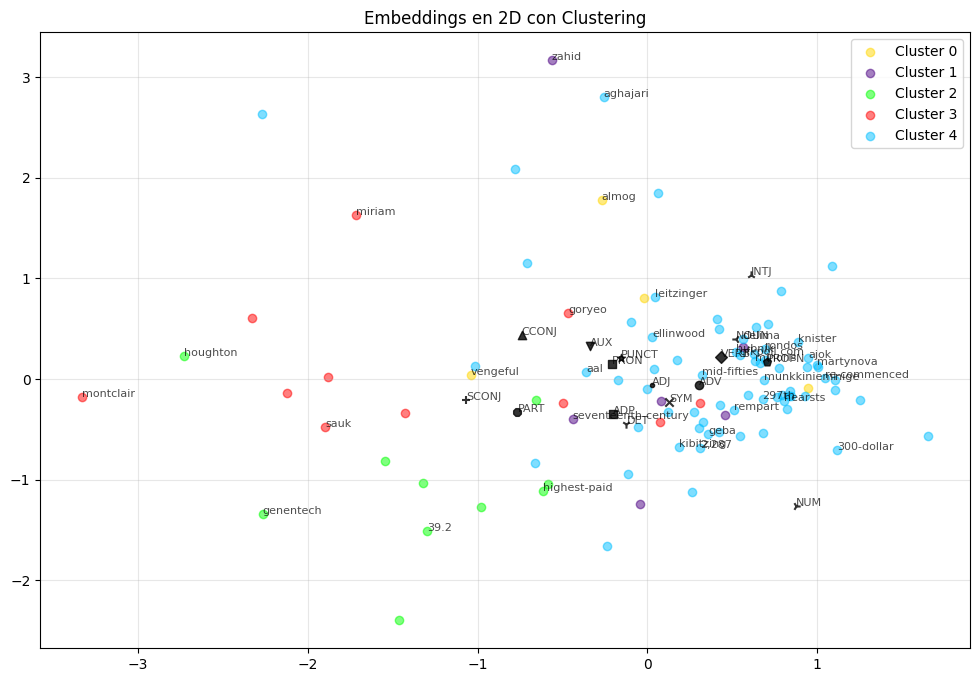

In [ ]:
# -----------------------------------------------------------
# Para embeddings estáticos con las etiquetas POS
# -----------------------------------------------------------
plot_clusters(static_embeddings, n_clusters=5, pos_embeddings=pos_embeddings_dynamic)


18


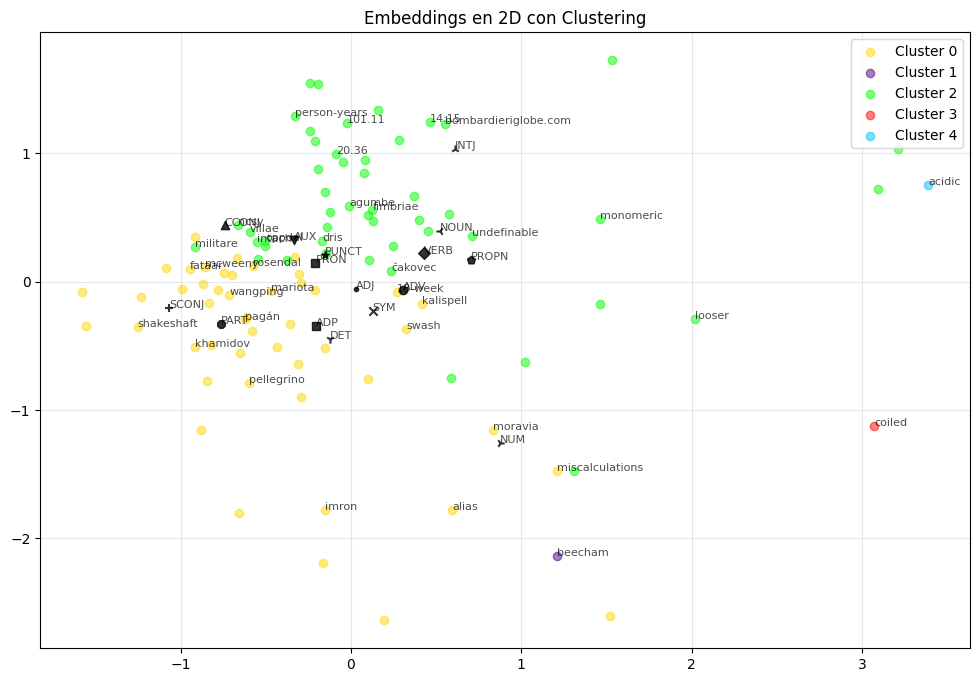

In [ ]:
# -----------------------------------------------------------
# Para embeddings dinámicos con las etiquetas POS
# -----------------------------------------------------------
plot_clusters(dynamic_embeddings_dict, n_clusters=5, pos_embeddings=pos_embeddings_dynamic)


#Conclusiones
Recordemos que los embeddings estáticos (GloVe) son representaciones que están basadas en un DSM, de esta forma al hacer un agrupamiento tienden a agruparse en clusters que reflejan relaciones semánticas y de significado. Por otro lado, los embeddings dinámicos fueron obtenidos de la RNN utilizada para clasificar las etiquetas POS, por lo que pueden estar mejor adaptados a la tarea de etiquetado POS específicamente. Esto lo podemos ver en nuestras dos gráficas, donde vemos que en la parte dinámica podemos ver dos grandes culteres que parecen pertenecer a diferentes etiquetas POS, pero que, están relacionadas entre sí. Por otro lado, en la parte estática podemos observar menos consistentes a los clusteres, y no se ve que haya una clara tendencia hacia una etiqueta POS, lo cual es normal, pues en este caso dichos embeddings están más relacionados por su significado que por su etiqueta POS como lo es en el caso de los embeddings dinámicos. También cabe aclarar que dicho análisis puede variar pues se toma una muestra de 100 palabras al azar.